In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb import *

# Load Norman data from Norman et al 2019

In [3]:
adata = sc.read_h5ad('./data/Norman_et_al_data/norman_file.h5ad')
adata.obs['n_counts'] = adata.layers['counts'].sum(axis=1)
adata.obs['n_features'] = (adata.layers['counts'] > 0).sum(1)
my_observation = torch.tensor(adata.X.todense() * 1.0, dtype=torch.float)

my_cell_info = adata.obs[['n_counts', 'n_features']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 1] = my_cell_info[:, 1] / my_cell_info[:, 0]
my_cell_info[:, 0] = torch.log(my_cell_info[:, 0])

condition_set = [[__ for __ in _.split('+')] for _ in list(adata.obs.condition.unique())]
unique_pert = list(set([x for xs in condition_set for x in xs]))
my_conditioner = np.zeros((adata.obs.shape[0], len(unique_pert)))
pert_lookup = {_:__ for __, _ in enumerate(unique_pert)}
cond_list = list(adata.obs.condition)
for i in range(adata.obs.shape[0]):
    perts = [__ for __ in cond_list[i].split('+')]
    my_id = [pert_lookup[_] for _ in perts]
    for j in my_id:
        my_conditioner[i, j] = 1
my_conditioner = torch.tensor(my_conditioner * 1.0, dtype=torch.float)

# Specify and train Gaussian GPerturb

In [8]:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000  
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 1e-3  
tau = torch.tensor(1.0).to(device)

parametric_model = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                               data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                               hidden_layer_2=hidden_layer, tau=tau)
parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('GPerturb_Norman_Gaussian_ref.pt'))
parametric_model=parametric_model.to('cpu')

<All keys matched successfully>

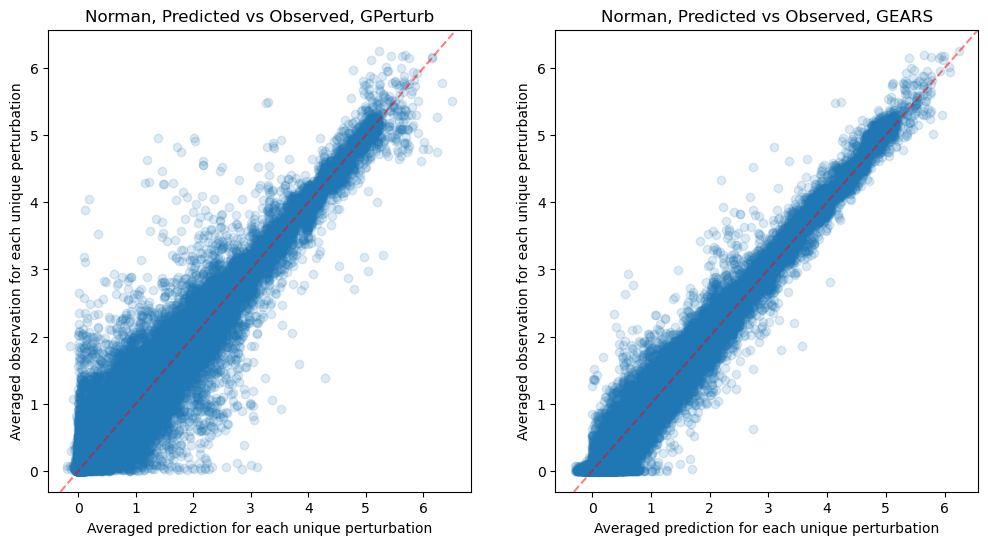

In [8]:
# finding averaged predictions for each of the two-gene perturbation

# compute from model
# cond_list_2 = [_.split('+') for _ in cond_list]
# for _ in cond_list_2:
#     if 'ctrl' in _:
#         _.remove('ctrl')
# cond_list_2 = np.array([['_'.join(_), '_'.join(_[::-1])] for _ in cond_list_2])

# avg_pred = np.zeros((gears_pred.shape[0], gears_pred.shape[1]))
# avg_obs = np.zeros((gears_pred.shape[0], gears_pred.shape[1]))
# for i, pert in enumerate(gears_pred.index):
#     if i%10 == 0:
#         print(i)
#     my_id = np.arange(len(cond_list))[[gears_pred.index[i] in _ for _ in cond_list_2]]
#     my_id = list(set(testing_idx) & set(my_id))
#     if len(my_id) != 0:
#         predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
#             logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[my_id],
#                                                                              my_cell_info[my_id])
#         estimated_base_mean = predicted_base_mean.detach().cpu().numpy()  # * zeros[testing_idx].numpy()
#         estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
#         avg_pred[i] = (estimated_perturbed_mean + estimated_base_mean).mean(0)
#         avg_obs[i] = my_observation[my_id].mean(0).numpy()
# avg_pred = avg_pred[avg_pred.mean(1) != 0]
# avg_obs = avg_obs[avg_obs.mean(1) != 0]

# load from pre-computed
gears_pred = pd.read_csv('./GPerturb_vis_data/Norman_GEARS_pred.csv', index_col=0)
avg_pred = np.load('./GPerturb_vis_data/GPerturb_Norman.npy')
avg_obs = np.load('./GPerturb_vis_data/avg_obs_Norman.npy')


fig, axes = plt.subplots(1, 2)
axes[0].scatter(avg_pred[avg_obs != 0], avg_obs[avg_obs != 0], alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Averaged prediction for each unique perturbation')
axes[0].set_ylabel('Averaged observation for each unique perturbation')
axes[0].set_title('Norman, Predicted vs Observed, GPerturb')

axes[1].scatter(gears_pred.to_numpy().ravel(), avg_obs.ravel(), alpha=0.15)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Averaged prediction for each unique perturbation')
axes[1].set_ylabel('Averaged observation for each unique perturbation')
axes[1].set_title('Norman, Predicted vs Observed, GEARS')

fig.set_size_inches(12,6)
# plt.savefig('Norman_GPerturb_vs_GEARS.png')
# plt.close()

# Specify and train ZIP/ZIGP GPerturb

In [8]:
# loading data
adata = sc.read_h5ad('./data/Norman_et_al_data/norman_file.h5ad')
adata.obs['n_counts'] = adata.layers['counts'].sum(axis=1)
adata.obs['n_features'] = (adata.layers['counts'] > 0).sum(1)
my_observation = torch.tensor(adata.layers['counts'] * 1.0, dtype=torch.float)

my_cell_info = adata.obs[['n_counts', 'n_features']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 1] = my_cell_info[:, 1] / my_cell_info[:, 0]
my_cell_info[:, 0] = torch.log(my_cell_info[:, 0])

condition_set = [[__ for __ in _.split('+')] for _ in list(adata.obs.condition.unique())]
unique_pert = list(set([x for xs in condition_set for x in xs]))
my_conditioner = np.zeros((adata.obs.shape[0], len(unique_pert)))
pert_lookup = {_:__ for __, _ in enumerate(unique_pert)}
cond_list = list(adata.obs.condition)
for i in range(adata.obs.shape[0]):
    perts = [__ for __ in cond_list[i].split('+')]
    my_id = [pert_lookup[_] for _ in perts]
    for j in my_id:
        my_conditioner[i, j] = 1
my_conditioner = torch.tensor(my_conditioner * 1.0, dtype=torch.float)


start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 5e-4  # 7e-4 works, 2e-3 kinda works
nu_1, nu_2, nu_3, nu_4 = torch.tensor(1.).to(device), torch.tensor(0.1).to(device), torch.tensor(1.).to(device), torch.tensor(0.1).to(device)
tau = torch.tensor(1.).to(device)

parametric_model = GPerturb_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                                base_dim=cell_info_dim, data_size=sample_size,
                                hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                hidden_layer_2=hidden_layer, tau=tau)

# # to use the Gamma Poisson (Negative binomial) model, call
# parametric_model = GPerturb_ZINB(conditioner_dim=conditioner_dim, output_dim=output_dim,
#                                  base_dim=cell_info_dim, data_size=sample_size,
#                                  hidden_node=hidden_node, hidden_layer_1=hidden_layer,
#                                  hidden_layer_2=hidden_layer, tau=tau)

parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 nu_1=nu_1, nu_2=nu_2, nu_3=nu_3, nu_4=nu_4, lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('GPerturb_Norman_ZIP_ref.pt'))

# loading the ZINB model
# parametric_model.load_state_dict(torch.load('GPerturb_Norman_ZINB_ref.pt'))

parametric_model=parametric_model.to('cpu')

# Comparing ZIP/ZIGP fit

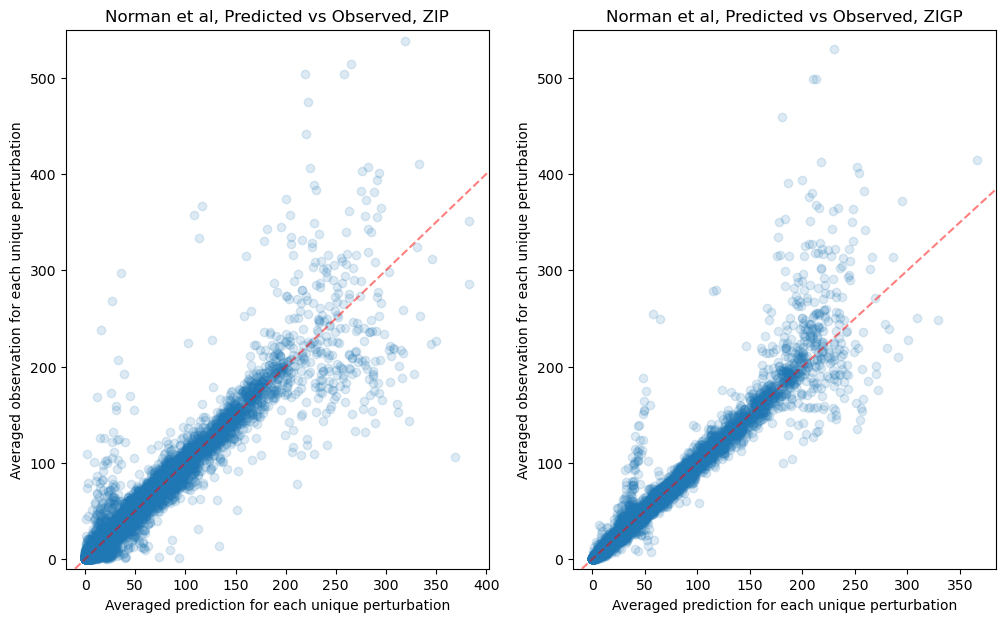

In [4]:
# finding averaged predictions for each of the unique perturbation

# avg_pred = np.zeros((len(np.unique(cond_list)), adata.X.shape[1]))
# avg_obs = np.zeros((len(np.unique(cond_list)), adata.X.shape[1]))
# for i, _ in enumerate(np.unique(cond_list)):
#     if i%10 == 0:
#         print(i)
#     my_id = np.arange(len(cond_list))[_ == np.array(cond_list)]
#     my_id = list(set(testing_idx) & set(my_id))
#     if len(my_id) != 0:
#         predicted_mu_mean, predicted_mu_var, predicted_base_mean, logit_p, logit_p_log_var = parametric_model(
#             my_conditioner[my_id], my_cell_info[my_id])
#         estimated_base_mean = predicted_base_mean  # * zeros[testing_idx].numpy()
#         estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
#         avg_pred[i] = logexpp1(estimated_perturbed_mean + estimated_base_mean).detach().cpu().numpy().mean(0)
#         avg_obs[i] = my_observation[my_id].mean(0).numpy()

# loading from the precomputed

fig, axes = plt.subplots(1, 2)
avg_pred = np.loadtxt('./GPerturb_vis_data/norman_avg_pred_GPerturb_zip.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/norman_avg_obs_GPerturb_zip.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[0].scatter(avg_pred, avg_obs, alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Averaged prediction for each unique perturbation')
axes[0].set_ylabel('Averaged observation for each unique perturbation')
axes[0].set_title('Norman et al, Predicted vs Observed, ZIP')
axes[0].set_ylim(-10, 550)

avg_pred = np.loadtxt('./GPerturb_vis_data/norman_avg_pred_GPerturb_zinb.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/norman_avg_obs_GPerturb_zinb.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[1].scatter(avg_pred, avg_obs, alpha=0.15)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Averaged prediction for each unique perturbation')
axes[1].set_ylabel('Averaged observation for each unique perturbation')
axes[1].set_title('Norman et al, Predicted vs Observed, ZIGP')
axes[1].set_ylim(-10, 550)
fig.set_size_inches(12, 7)
# plt.savefig('Norman_count.png')
# plt.close()